### Plano de hoje:

- Ambiente de programação
- Usando o computador para calcular
- Usando o computador para desenhar
- 1. **Traçando secantes e tangentes (derivadas)**
- 2. **Animações e aproximações: algoritmo de secantes para achar zeros _vs_ Newton**

# Derivadas aproximadas

 Nem sempre é possível calcular a derivada de uma função.
 Às vezes, a função em questão não é dada de forma explícita.
 Por exemplo, para
$$f(x) = \min_{|y| < x} \big( \frac{\cos(2x^2 - 3y)}{20x - y}  \big).$$

Assim, teremos que _estimar_ a derivada de $f$, sem calculá-la explicitamente.


 A idéia principal é que
 $$ f'(x) = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h}, $$
 ou seja, que a derivada é o limite do "quociente fundamental".
 Podemos usar o computador para estimar este limite:

In [1]:
def df(f, x, eps=1e-5):
    return (f(x+eps) - f(x))/eps

In [9]:
from numpy import arange, cos, sin

In [11]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


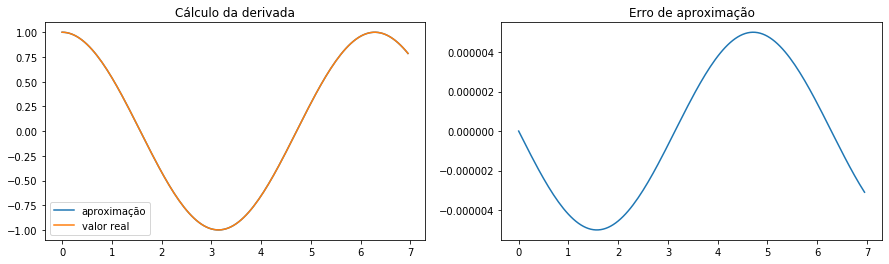

In [12]:
x = arange(0., 7., 0.05)
dfx = cos(x)
dfx_approx = df(sin,x)

figure(figsize=(15,4))
subplot(1,2,1)
title('Cálculo da derivada')
plot(x, dfx_approx, label='aproximação')
plot(x, dfx, label='valor real')
legend(loc=0)

subplot(1,2,2)
title('Erro de aproximação')
plot(x, dfx_approx - dfx);


# Estimando o erro
 
 Uma atividade importante ao se construir um método aproximativo é calcular (ou estimar) o erro cometido.
 Em geral, estimativas de erros são feitas com mais do que as hipóteses mínimas para o método.
 Por exemplo, no caso do método de Newton, basta a função ser derivável, mas para mostrar convergência quadrática,
 temos que supor que ela terá duas derivadas, e que esta seja limitada no intervalo de convergência.
 
 Vamos, então, seguir este padrão: queremos calcular a primeira derivada,
 e para estimar o erro suporemos que a função é duas vezes derivável.
 Assim:
 $$ \frac{f(x+h) - f(x)}{h} - f'(x) = \frac{\big(f(x) + h f'(x) + \frac{h^2}{2} f''(\xi) \big) - f(x)}{h} - f'(x)
    = \frac{h f''(\xi)}{2} $$
#### onde (como em Newton) $\xi \in (x, x+h)$ é um ponto intermediário.


 No caso anterior onde $f(x) = \sin(x)$, temos portanto que o erro será $h (-\sin(\xi))/2 = - h \sin(\xi)/2$.
 Comparemos com $h \sin(x)/2$, que deve ser bem próximo, já que $\xi \in (x, x+h)$:

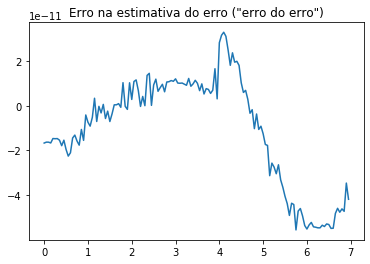

In [13]:
title('Erro na estimativa do erro ("erro do erro")')
plot(x, (dfx_approx - dfx) - (- 1e-5 * sin(x) / 2));


# Diferenças centrais
 
 O exemplo anterior mostra que, se vamos aproximar a derivada de uma função "bem-comportada" pelo quociente fundamental,
 o erro será proporcional ao **passo** e à derivada segunda.
 Assim, para diminuir o erro, teremos que diminuir igualmente o passo.
 Mas isso pode resultar em erros de truncamento...

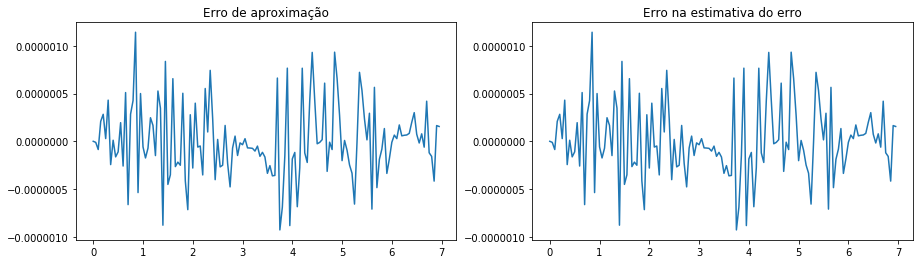

In [14]:
dfx_approx_2 = df(sin,x, eps=1e-10)

figure(figsize=(15,4))
subplot(1,2,1)
title('Erro de aproximação')
plot(x, dfx_approx_2 - dfx);

subplot(1,2,2)
title('Erro na estimativa do erro')
plot(x, (dfx_approx_2 - dfx) - (- 1e-10 * sin(x)/2));

  Para resolver isso, precisamos de um método de cálculo cujo erro seja menor!
  
  Se uma função é 2 vezes derivável, temos que
  $$ f(x+h) = f(x) + h f'(x) + \frac{h^2}{2} f''(x) + o(h^2) $$
  onde $o(h^2)$ é um termo **muito pequeno** quando comparado com $h^2$.
  
  Um outro quociente fundamental é
  $$ f'(x) = \lim_{h \to 0} \frac{f(x+h) - f(x-h)}{2h}. $$
  Ao usar as fórmulas de Taylor acima até a ordem 2 para calcular as aproximações,
  vemos que os termos de ordem *par* se anulam:
  $$ \frac{f(x+h) - f(x-h)}{2h}
     = \frac{\big(f(x) + h f'(x) + \frac{h^2}{2} f''(x) + o(h^2)\big)
     - \big( f(x) - h f'(x) + \frac{h^2}{2} f''(x) + o(h^2) \big)}{2h} = o(h). $$
  Assim, este método é bem melhor do que o anterior quando a função é duas vezes derivável.
  
  Mais ainda: se ela fosse três vezes derivável, poderíamos explicitar $o(h^2) = \frac{h^3}{6} f'''(\xi)$,
  e assim obteríamos um erro $ \frac{h^2}{6} f''' $.
  Vejamos o que acontece para o seno:

In [15]:
def df_sym(f,x,eps=1e-5):
    return (f(x+eps) - f(x-eps))/(2*eps)

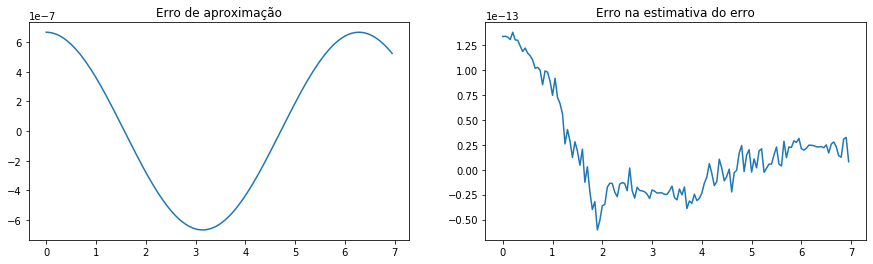

In [16]:
h = 0.2e-2
dfx_approx_3 = df_sym(sin,x,eps=h)

figure(figsize=(15,4))
subplot(1,2,1)
title('Erro de aproximação')
plot(x, dfx - dfx_approx_3);

subplot(1,2,2)
title('Erro na estimativa do erro')
plot(x, (dfx_approx_3 - dfx) - (-(h ** 2) * cos(x)/6));


## Uma novidade: funções que retornam funções

Pode parecer estranho a primeira vista, pois estamos acostumados a que uma função retorne um "valor",
algo como um número, uma _string_, uma lista, ...
Mas em Python podemos retornar uma função, isso também é um "valor" aceitável de retorno.
O caso básico de utilização desta idéia é construir uma função _diferente_ para situações diferentes.

Vejamos como isso se aplica na secante: a secante é dada por dois pontos
$(x, f(x))$ e $(y, f(y))$.
Mas, para desenhar a secante junto com o gráfico da função,
precisamos da **função afim** correspondente.
Assim, dadas a função $f$ e as duas abscissas $x$ e $y$,
construimos a função afim e retornamos a mesma.


In [17]:
def sec(f,x,y):
    base = f(x)
    incl = (f(y) - f(x))/(y - x)
    def linha(z):
        return (z - x)*incl + base
    return linha

In [18]:
secantes = []
for alvo in [2, 1, 0.5, 0.1]:
    secantes.append( (alvo, sec(sin,0,alvo)) )

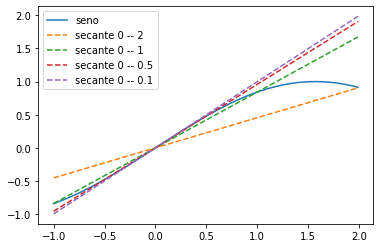

In [19]:
x = arange(-1, 2, 0.01)
plot(x, sin(x), label='seno')
for (alvo,s) in secantes:
    plot(x, s(x), '--', label='secante 0 -- ' + str(alvo))
legend(loc=0);

# O método de Newton com aproximação da secante

Podemos modifiar o método de Newton para que ele calcule não a derivada (que podemos não saber calcular de forma simples!)
mas uma aproximação da mesma.
Temos assim um método dependendo de dois valores:
$$z = x - \frac{f(x)}{\frac{f(y) - f(x)}{y - x}} = x - \frac{f(x)\big( y - x \big)}{f(y) - f(x)} = \frac{x f(y) - y f(x)}{f(y) - f(x)}$$
onde $y$ é um outro ponto.
No caso de um método iterativo, podemos usar outros pontos de $f$ já calculados!

<codecell>

In [21]:
def newton_sec(f,x0,x1, tolx=1e-10, maxiter=100):
    ## Fazer em aula
    pass

## Performance

O "método da secante", como é conhecido, converge mais lentamente do que o método de Newton:
podemos mostrar que os erros $e_i$ satisfazem uma "recorrência de desigualdade":
$$ e_{n+1} < C (e_n \cdot e_{n-1}). $$
Mas, como este calcula menos vezes a função, ele converge mais rápido por número de chamadas a $f$.

**Exercício**: Fazer uma comparação entre as velocidades de Newton e da Secante. Se tiver tempo, faça desenhos indicando os pontos das iterações.
Se tiver mais tempo ainda, calcule o tempo de execução de cada um. Enfim, anime o desenho "ao longo do tempo", fazendo aparecer os pontos de Newton e da secante "na ordem temporal em que foram calculados".